cnsts.shape=(98758, 100, 3)


jets.shape=(98758, 3)


The smallest jet_pt is: 450.00129118847076
The biggest jet_pt is: 999.8620172940161


number of particles loaded: 5365439
number of particles with R=0: 1
percentage of particles with R=0: 0.0%
number of particles with R>=1.0: 14630
percentage of particles with R>=1.0: 0.273%


num_pt_bins=55


num_R_bins=99




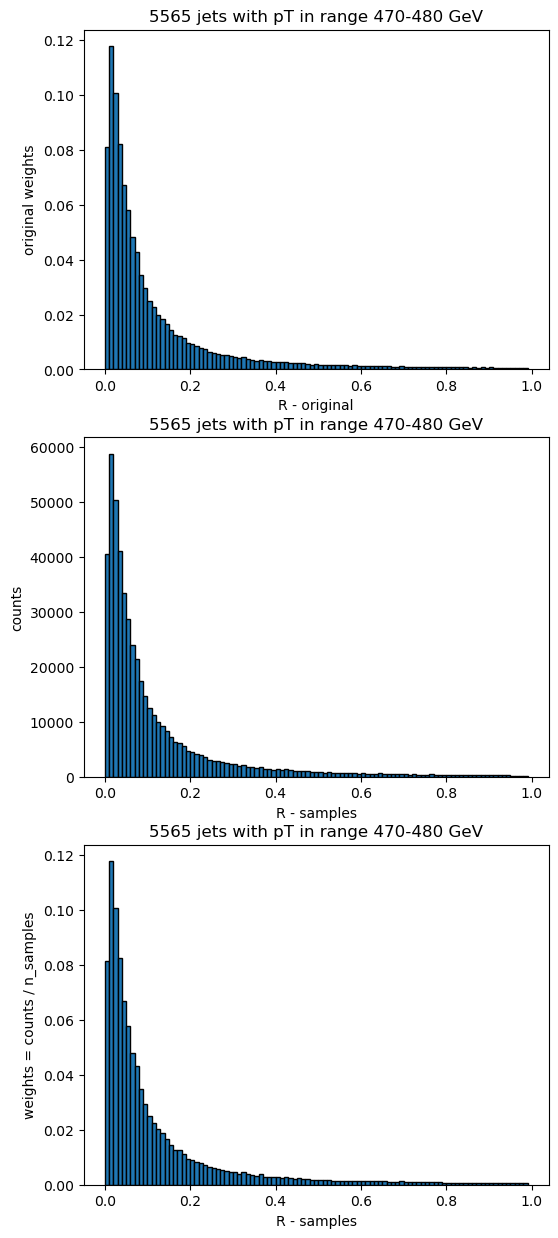

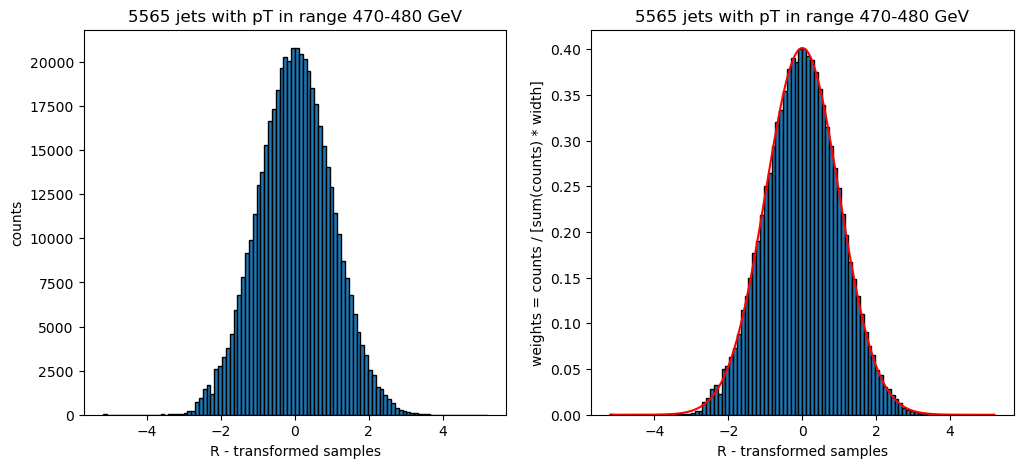

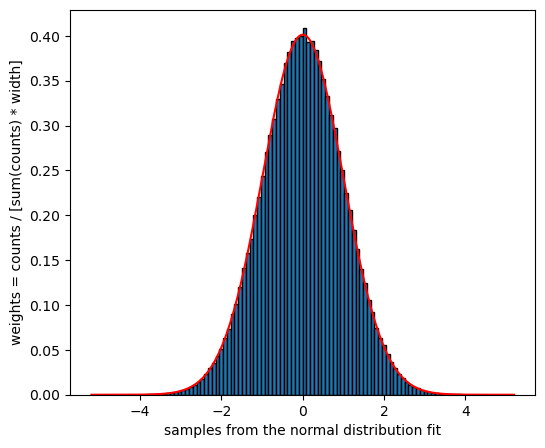

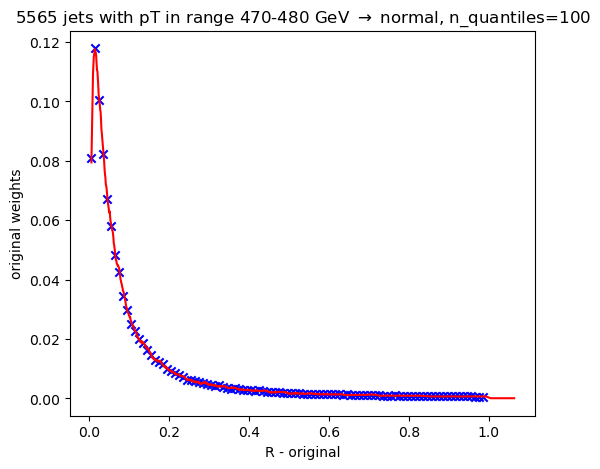

In [1]:
import sys
sys.path.append("./")

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from data_inspect import *
from scipy.stats import norm
from sklearn.preprocessing import QuantileTransformer

# **SETTING THE DATA STRUCTURE:**

# The input HDF5 file containing the relevant jets:
input = "QCDjj_pT_450_1200_train01.h5" #change if needed

# The number of jets to load:
n_jets = 100_000 #change if needed

# Jet pt range:
min_pt=450 #change if needed
max_pt=1000 #change if needed
width_pt=10

# Choosing only the jets from the set jet pt range
with h5py.File(input, "r") as f:
    
    mask_pt=[index for index,value in enumerate(
        f["objects/jets/jet1_obs"][:n_jets,0]) 
             if ((value>=min_pt) and (value<=max_pt))]

R_max=1.0
width=0.01

jets=read_data(input,mask_pt)

#-------------------------------------------------------------------------------

# **R DISTRIBUTION OF JETS:**

#phi angle differences between the constituents and the associated jet:
#rows -> jets ; columns -> particles
delta_phi=jets['jet_phi'].reshape(-1,1)-jets['part_phi']

#because the phi angle difference should be inside [-np.pi,+np.pi]:
delta_phi_new=np.ma.mod(delta_phi+np.pi,2*np.pi)-np.pi

#eta angle differences between the constituents and the associated jet:
#rows -> jets ; columns -> particles
delta_eta=jets['jet_eta'].reshape(-1,1)-jets['part_eta']

#rows -> jets ; columns -> particles
R=np.ma.sqrt(delta_eta**2+delta_phi_new**2)
    
print(f"number of particles loaded: \
{len(R.compressed())}")

print(f"number of particles with R=0: \
{len(np.where(R.compressed()==0.0)[0])}")

print(f"percentage of particles with R=0: \
{np.round(len(np.where(R.compressed()==0.0)[0])*100/len(R.compressed()),3)}%")

print(f"number of particles with R>={R_max}: \
{len(np.where(R.compressed()>=R_max)[0])}")

print(f"percentage of particles with R>={R_max}: \
{np.round(len(np.where(R.compressed()>=R_max)[0])*100/len(R.compressed()),3)}%")
    
print(f"\n")
    
jets['part_pt']=np.ma.masked_where(R<0,jets['part_pt'])
jets['part_pt']=np.ma.masked_where(R>=R_max,jets['part_pt'])

R=np.ma.masked_where(R<0,R)
R=np.ma.masked_where(R>=R_max,R)
    
#-------------------------------------------------------------------------------

# **SETTING pT BINS:**

bins_pt=np.arange(min_pt,max_pt+width_pt,width_pt)
pt_middles = (bins_pt[1:]+bins_pt[:-1])/2.
num_pt_bins=len(pt_middles)

print(f"num_pt_bins={num_pt_bins}")
print(f"\n")

#-------------------------------------------------------------------------------
    
# **SETTING R BINS:**

bins_r=np.arange(0,R_max,width)
R_middles = (bins_r[1:]+bins_r[:-1])/2.
num_R_bins=len(R_middles)

print(f"num_R_bins={num_R_bins}")
print(f"\n",flush=True)

#-------------------------------------------------------------------------------

mask_binpt=[]

for k in range(num_pt_bins):

        mask_binpt.append([index for index,value in enumerate(
            jets['jet_pt']) if ((value>bins_pt[k]) 
                                and (value<=bins_pt[k+1]))])
        
num_jets=[len(sublist) for sublist in mask_binpt]
        
#-------------------------------------------------------------------------------


# **CREATING THE HISTOGRAM AND CALCULATING ITS COVARIANCE MATRIX**

idx=2

weights=jets['part_pt'][mask_binpt[idx]]

hist,cov_matrix=hist_cov(R[mask_binpt[idx]],bins_r,weights)

#-------------------------------------------------------------------------------

# **SAMPLING:**

weights=weights/(num_jets[idx]*np.sum(weights,axis=1).reshape(-1,1))

n_samples = 500000
data = np.random.choice(R[mask_binpt[idx],:].compressed(),
                        size=n_samples,p=weights.compressed())

#-------------------------------------------------------------------------------

# **SAMPLING VISUALIZED:**

if not os.path.exists("./Plots"):
    os.makedirs("./Plots")

fig,ax=plt.subplots(3,1,figsize=(6,15))

ax[0].set_title(f"{num_jets[idx]} jets with pT in range "
                f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax[0].bar(R_middles,hist,width=width,ec='black')
ax[0].set_xlabel("R - original")
ax[0].set_ylabel("original weights")

ax[1].set_title(f"{num_jets[idx]} jets with pT in range "
                f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax[1].hist(data,bins=bins_r,ec='black')
ax[1].set_xlabel("R - samples")
ax[1].set_ylabel("counts")

a=1/n_samples*np.ones(shape=n_samples)
ax[2].set_title(f"{num_jets[idx]} jets with pT in range "
                f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax[2].hist(data,bins=bins_r,weights=a,ec='black')
ax[2].set_xlabel("R - samples")
ax[2].set_ylabel("weights = counts / n_samples")

fig.savefig("./Plots/sampling.jpg")

#-------------------------------------------------------------------------------

# **TRANSFORMING SAMPLED R, PLOTTING IT AND FITTING**:

# Choose either "uniform" or "normal":
choice="normal" 

# Setting the transformer
n_quantiles=100
qt = QuantileTransformer(
    output_distribution=choice,subsample=None,n_quantiles=n_quantiles)

# Transforming:
data_trans = qt.fit_transform(X=data.reshape(-1,1))

fig,ax=plt.subplots(1,2,figsize=(12,5))

ax[0].set_title(f"{num_jets[idx]} jets with pT in range "
                f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax[0].hist(data_trans,bins=len(bins_r),ec='black')
ax[0].set_xlabel("R - transformed samples")
ax[0].set_ylabel("counts")

if choice=="uniform":
    # Fitting uniform:
    x=np.linspace(min(data_trans.flatten()),max(data_trans.flatten()),10000)
    pdf=np.ones(len(x))*1/(max(data_trans.flatten())-min(data_trans.flatten()))

elif choice=="normal":
    # Fitting a Gaussian:
    x=np.linspace(min(data_trans.flatten()),max(data_trans.flatten()),10000)
    mu,sigma = norm.fit(data_trans)
    pdf = norm.pdf(x,loc=mu,scale=sigma)

ax[1].set_title(f"{num_jets[idx]} jets with pT in range "
                f"{bins_pt[idx]}-{bins_pt[idx+1]} GeV")
ax[1].plot(x, pdf, 'r-')
ax[1].hist(data_trans,bins=len(bins_r),ec='black',density=True)
ax[1].set_xlabel("R - transformed samples")
ax[1].set_ylabel("weights = counts / [sum(counts) * width]")

fig.savefig(f"./Plots/trans_{choice}.jpg")
                
#-------------------------------------------------------------------------------

# **SAMPLING FROM THE FITTED DISTRIBUTION:**

prob=pdf/np.sum(pdf)
samples = np.random.choice(x,size=n_samples,p=prob)

plt.figure(figsize=(6,5))
plt.hist(samples,bins=len(bins_r),density=True,ec='black')
plt.plot(x,pdf,'r-')
plt.xlabel(f"samples from the {choice} distribution fit")
plt.ylabel("weights = counts / [sum(counts) * width]")
plt.savefig(f"./Plots/samples_{choice}.jpg")

#-------------------------------------------------------------------------------

# **TRASNFORMING THE FIT BACK TO THE ORIGINAL SPACE**:

samples_back=qt.inverse_transform(samples.reshape(-1,1))

hist_fit=[]
middles_fit=[]

# Making the fit as smooth as possible
dif=0.001
for i in range(0,70):
    h, be = np.histogram(samples_back.flatten(),
                         bins=len(bins_r),weights=a,range=(0+dif*i,R_max+dif*i)) 
    hist_fit.extend(h)
    bm = (be[1:]+be[:-1])/2.
    middles_fit.extend(bm)
    
sorting=np.argsort(np.argsort(middles_fit))
hist_fit = [val for _, val in sorted(zip(sorting,hist_fit))]
middles_fit=[val for _, val in sorted(zip(sorting,middles_fit))]

#-------------------------------------------------------------------------------

# **PLOT OF THE FIT IN THE ORIGINAL SPACE**:

plt.figure(figsize=(6,5))
plt.title(f"{num_jets[idx]} jets with pT in range "
          fr"{bins_pt[idx]}-{bins_pt[idx+1]} GeV $\rightarrow$ {choice}, "
          f"n_quantiles={n_quantiles}")
plt.scatter(R_middles,hist,color='b',marker='x')
plt.plot(middles_fit,hist_fit,'r-')
plt.xlabel("R - original")
plt.ylabel("original weights")
plt.savefig(f"./Plots/fit_{choice}.jpg")